# Time-Step Convergence for Diurnal Surface Temperatures

Objective: determine the minimum time step (via tsteps_day) needed so that the final diurnal-cycle surface temperatures (T_surf_out) are converged within 1 K at all output times.

Approach:
- Use manual time stepping: set auto_dt=False and control tsteps_day.
- Run successive simulations with increasing tsteps_day (shorter dt).
- Compare T_surf_out between consecutive runs; stop when the max absolute difference ≤ 1 K across all times.
- Do this for two rotation periods: a fast rotator (P=15450 s) and a lunar-like period (P = 29.5306 days).

Notes:
- Keep freq_out fixed so t_out aligns across runs, making comparisons direct.
- The model returns only the final diurnal cycle when last_day=True.
- RTE is enabled with the faster hapke option for speed; adjust as needed.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import sys, os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


from config import SimulationConfig
from modelmain import Simulator

np.set_printoptions(suppress=True, linewidth=120)


## Helpers: build config and run
We mirror the setup from Analyses/Lunar_diurnal_test.ipynb but force manual time stepping.


In [28]:
def build_config(period_s, tsteps_day, freq_out=200, ndays=3):
    # Construct a SimulationConfig for a diurnal run with manual dt.
    cfg = SimulationConfig(
        diurnal=True,
        sun=True,
        last_day=True,
        freq_out=freq_out,
        ndays=ndays,
        P=period_s,
        auto_dt=False,
        tsteps_day=int(tsteps_day),
        use_RTE=True,
        RTE_solver='disort',
        thermal_evolution_mode= 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
        Et = 7000,
        single_layer=True,
        T_surf_tol=1e-4,
        T_surf_max_iter=50,
        depth_dependent_properties= True,
        temperature_dependent_properties= True,
        temp_dependent_cp= True,
        temp_dependent_k= False,      #Only use for non-RTE model. Temperature-dependence of conductivity comes naturally in RTE model. 
        temp_change_threshold= 0.5,
        T_bottom= 260.0,
        eta= 1.0,                             #Vis/thermal extinction coefficient ratio. 
        ssalb_therm= 0.1,                     # Single scattering albedo for thermal radiation (average from mie code)
        g_therm= 0.0,                         # Asymmetry parameter for thermal radiation (average from mie code)
        ssalb_vis= 0.50,
        g_vis= 0.0,
        R_base= 0.0,                          # Global reflectivity value for substrate     
        disort_space_temp= 0.0,              # Cold shroud temperature
        dust_thickness= 5.0,
        em = 0.978,
        albedo= 0.115
    )
    cfg.__post_init__()
    return cfg

def run_model(cfg):
    # Run a simulation and return results with timing and dt.
    sim = Simulator(cfg)
    t0 = perf_counter()
    T_out, phi_vis, phi_therm, T_surf_out, t_out = sim.run()
    t1 = perf_counter()
    dt = cfg.P / cfg.tsteps_day
    return {
        'cfg': cfg,
        'dt': dt,
        'T_surf': np.array(T_surf_out),
        't_out': np.array(t_out),
        'runtime_s': t1 - t0,
    }

def max_abs_diff(a, b):
    return float(np.max(np.abs(np.asarray(a) - np.asarray(b))))


## Convergence search
Increment tsteps_day until the change in T_surf from the previous run is ≤ 1 K.
You can compare either across all output times or only at selected local times (e.g., 05:00 and 12:00).


In [29]:
def find_min_tsteps_for_convergence(period_s, start_tsteps=1000, max_tsteps=64000, grow_factor=1.6, freq_out=200, ndays=3, tol_K=1.0, verbose=True, compare_mode='all', target_hours=(5.0, 12.0)):
    runs = []
    errors = []
    tsteps = int(start_tsteps)
    converged_index = None

    if verbose:
        print('Period P = %.1f s' % period_s)
        if compare_mode == 'all':
            header = 'tsteps_day  dt[s]   max|dT| [K]   runtime[s]'
        else:
            header = 'tsteps_day  dt[s]   max|dT| [K] @ hours %s   runtime[s]' % (list(target_hours),)
        print(header)
        print('-' * len(header))

    prev_T = None
    i = 0
    while tsteps <= int(max_tsteps):
        cfg = build_config(period_s, tsteps, freq_out=freq_out, ndays=ndays)
        result = run_model(cfg)
        runs.append(result)
        if prev_T is None:
            err = None
        else:
            if compare_mode == 'all':
                err = max_abs_diff(result['T_surf'], prev_T)
            else:
                # Compare only at discrete local times
                t_hours = (result['t_out'] - result['t_out'][0]) / 3600.0
                idxs = [int(np.argmin(np.abs(t_hours - h))) for h in target_hours]
                diffs = [abs(result['T_surf'][ix] - prev_T[ix]) for ix in idxs]
                err = float(np.max(diffs)) if len(diffs) else np.nan
            if converged_index is None and err <= tol_K:
                converged_index = i
        errors.append(err)

        if verbose:
            if err is None:
                err_str = '      N/A'
            else:
                err_str = '%10.3f' % err
            print('%10d  %6.2f  %s  %9.2f' % (tsteps, result['dt'], err_str, result['runtime_s']))

        if converged_index is not None:
            break

        prev_T = result['T_surf']
        tsteps = int(np.ceil(tsteps * float(grow_factor)))
        i += 1

    return {
        'runs': runs,
        'errors': errors,
        'converged_index': converged_index,
        'tol_K': tol_K,
    }


## Execute: fast rotator and lunar-like period
Run both cases and report the minimal tsteps_day meeting the 1 K criterion.


In [30]:
P_fast = 15450.0
P_lunar = 29.5306 * 24 * 60 * 60

res_fast = find_min_tsteps_for_convergence(P_fast, start_tsteps=3000, max_tsteps=100000, grow_factor=1.8, freq_out=200, ndays=4, tol_K=0.2,compare_mode='not_all')
print()
res_lunar = find_min_tsteps_for_convergence(P_lunar, start_tsteps=50000, max_tsteps=500000, grow_factor=1.3, freq_out=200, ndays=2, tol_K=0.05,compare_mode = 'not_all')

def summarize(res, label):
    idx = res['converged_index']
    tol = res['tol_K']
    if idx is None:
        print('[WARN] %s: did not converge within limits.' % label)
        return None
    run = res['runs'][idx]
    tsteps = run['cfg'].tsteps_day
    dt = run['dt']
    err = res['errors'][idx]
    print('%s: converged at tsteps_day=%d (dt=%.3f s), max|dT|=%.3f K ≤ %.1f K' % (label, tsteps, dt, err, tol))
    return tsteps, dt, err

summary_fast = summarize(res_fast, 'Fast rotator')
summary_lunar = summarize(res_lunar, 'Lunar-like')


Period P = 15450.0 s
tsteps_day  dt[s]   max|dT| [K] @ hours [5.0, 12.0]   runtime[s]
----------------------------------------------------------------
Using depth-dependent properties:
  Surface density: 1100.0 kg/m³
  Deep density: 1800.0 kg/m³
  Surface conductivity: 7.40e-04 W/m/K
  Deep conductivity: 3.40e-03 W/m/K
Time step: 5.150429 s, Steps per day: 3000
Initial temperature-dependent heat capacity calculated (T=260.0K)
  cp range: 693.1 - 693.1 J/kg/K
Temperature-dependent property tracking initialized
Thermal evolution mode: two_wave
Time step 0/12000
Time step 600/12000
Time step 1200/12000
Time step 1800/12000
Time step 2400/12000
Time step 3000/12000
Time step 3600/12000
Time step 4200/12000
Time step 4800/12000
Time step 5400/12000
Time step 6000/12000
Time step 6600/12000
Time step 7200/12000
Time step 7800/12000
Time step 8400/12000
Time step 9000/12000
Time step 9600/12000
Time step 10200/12000
Time step 10800/12000
Time step 11400/12000
Simulation completed in 3.15 s
  

## Plots and diagnostics
- Overlay T_surf for the last two runs (pre- and post-convergence).
- Error vs. time-step size.


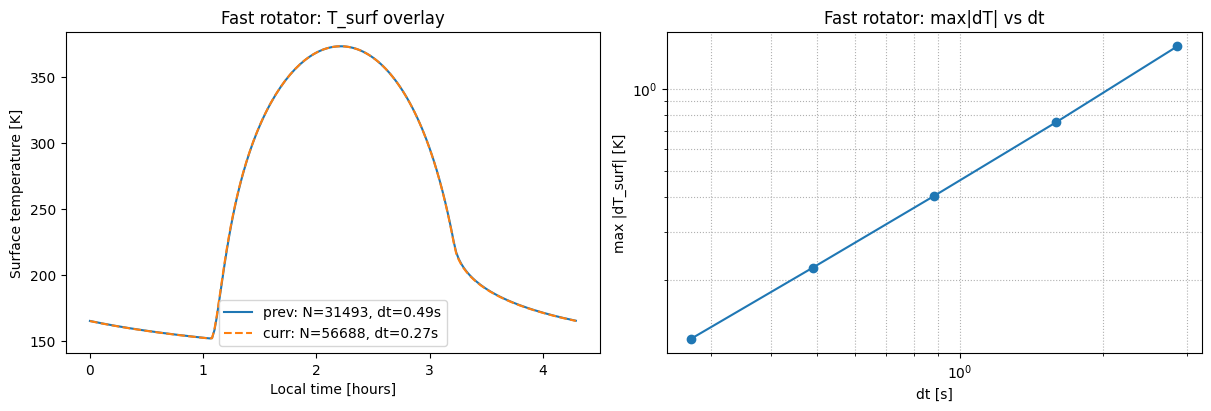

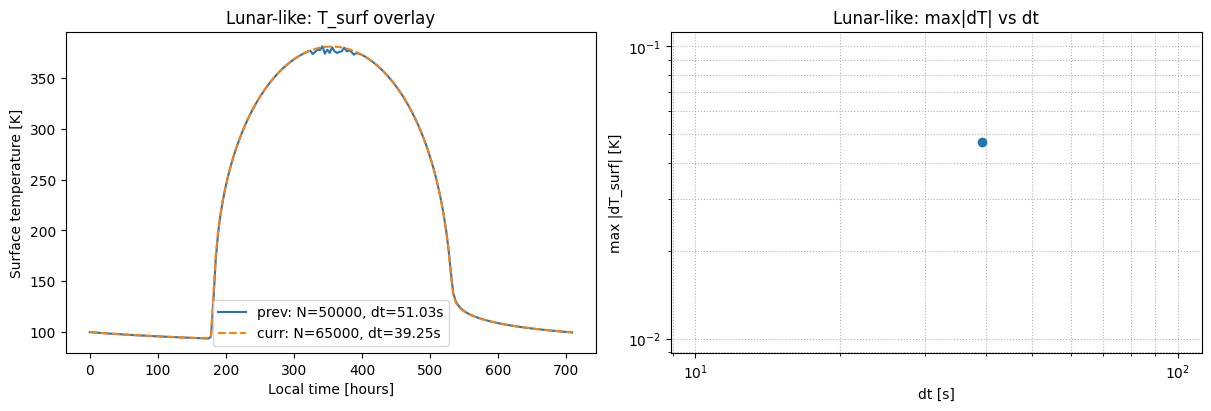

In [26]:
def plot_overlays(res, label):
    idx = res['converged_index']
    runs = res['runs']
    if idx is None or idx == 0:
        print('No overlay for %s (not converged or single run).' % label)
        return
    r_prev = runs[idx-1]
    r_curr = runs[idx]
    time_hours = (r_curr['t_out'] - r_curr['t_out'][0]) / 3600.0

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    ax = axes[0]
    ax.plot(time_hours, r_prev['T_surf'], label='prev: N=%d, dt=%.2fs' % (r_prev['cfg'].tsteps_day, r_prev['dt']))
    ax.plot(time_hours, r_curr['T_surf'], label='curr: N=%d, dt=%.2fs' % (r_curr['cfg'].tsteps_day, r_curr['dt']), linestyle='--')
    ax.set_title('%s: T_surf overlay' % label)
    ax.set_xlabel('Local time [hours]')
    ax.set_ylabel('Surface temperature [K]')
    ax.legend()

    ax = axes[1]
    dts = [r['dt'] for r in runs]
    errs = [e if e is not None else np.nan for e in res['errors']]
    ax.loglog(dts[1:], errs[1:], marker='o')
    ax.set_title('%s: max|dT| vs dt' % label)
    ax.set_xlabel('dt [s]')
    ax.set_ylabel('max |dT_surf| [K]')
    ax.grid(True, which='both', linestyle=':')

    plt.show()

plot_overlays(res_fast, 'Fast rotator')
plot_overlays(res_lunar, 'Lunar-like')


## Next steps
This notebook is structured to expand into parameter sweeps, e.g., varying grid spacing and material properties, to examine how the minimum time step depends on grid and physical parameters.
Add sweeps by iterating over additional parameter lists and calling find_min_tsteps_for_convergence for each combination, aggregating the results into a table.
